In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib.colors import Normalize
import os

In [93]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Amelie/Processed_data/'
OUTPUT_PATH = os.path.join(MAIN_PATH, f'Results/CNN')
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [94]:
DIVs = [27, 28, 32, 35, 42]
Chip_ID_ngn2 = ['1908','1765','1821']
chip_id_ngn2_int = [2908, 1765, 1821]
Chip_ID_gaba = ['2034','2074']
chip_id_gaba_int = [2034, 2074]

#dataset = f"/Volumes/violam/neuronies/single_neurons/3_Student_Projects/Amelie/Datasets/DIVS{DIVs}_full_dataset.csv"
#dataset = os.path.join(MAIN_PATH, 'Results/extremum_results_final.pkl')
dataset = os.path.join(MAIN_PATH, 'Results/waveforms_all.pkl')
df_original = pd.read_pickle(dataset)


In [95]:
df = df_original[df_original['cell_type'] != 'CoCulture']
df.dropna(inplace = True)
df = df[df['chip_id'].isin([chip_id_ngn2_int[0], chip_id_ngn2_int[1], chip_id_gaba_int[0], chip_id_gaba_int[1]])]
df['Type'] = df['cell_type'].apply(lambda x: 0 if x == 'NGN2' else 1)


/tmp/ipykernel_26131/2183861359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


In [96]:



#make column Type that is 0 if cell_type == NGN2 and 1 if cell_type == GABA
df['Type'] = df['cell_type'].apply(lambda x: 0 if x == 'NGN2' else 1)
df = df[(df['div'].astype(int).isin(DIVs))]
df.reset_index(drop=True, inplace=True)

In [97]:
df_waveforms = df
df

,unit_id,waveform,chip_id,div,cell_type,area,Type
0,0,"[-21.635912, -20.693197, -29.131996, -32.37711...",2034,35,GABA,3,1
1,0,"[-42.504993, -25.51953, -21.880621, -27.309076...",2034,35,GABA,3,1
2,0,"[-39.31449, -46.459408, -49.400185, -51.81818,...",2034,35,GABA,3,1
3,0,"[-24.91021, -18.352684, -9.759934, -10.693138,...",2034,35,GABA,3,1
4,0,"[-30.647999, -24.905577, -25.895208, -25.90824...",2034,35,GABA,3,1
...,...,...,...,...,...,...,...
334297,58,"[9.762502, 3.4972281, -9.94349, -0.34092736, 1...",1765,35,NGN2,2,0
334298,58,"[1.1037774, 0.30968425, 10.738535, 27.245703, ...",1765,35,NGN2,2,0
334299,58,"[11.440228, 22.252226, 18.75905, 7.0568037, 5....",1765,35,NGN2,2,0
334300,58,"[-9.246086, -9.361642, -9.774623, -12.6780205,...",1765,35,NGN2,2,0


In [98]:
best_waveform_array = np.array(df['waveform'].tolist())
print(best_waveform_array.shape)
reshaped_data = best_waveform_array[..., np.newaxis]
print(reshaped_data.shape)

(334302, 80)
(334302, 80, 1)


In [99]:
X = reshaped_data
y = df_waveforms['Type'].values

# Convert DataFrame to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into train and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size= 0.3, random_state=42, stratify=y_tensor)

# Split the data into train and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size= 0.5, random_state=42, stratify=y_temp)
print(y_val.shape)

# Normalize the training data (X_train)
mean = X_train.mean()
std = X_train.std()
X_train_normalized = (X_train - mean) / std

# Normalize the validation/test data using the same mean and std
X_val_normalized = (X_val - mean) / std
X_test_normalized = (X_test - mean) / std



torch.Size([50145])


In [100]:
# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(X_train_normalized, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val_normalized, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Use mini-batches instead of full-batch training
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

/tmp/ipykernel_26131/134935946.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_normalized, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
/tmp/ipykernel_26131/134935946.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(X_val_normalized, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))


In [101]:
# Class weights
num_positive = y_train.sum()
num_negative = len(y_train) - num_positive
pos_weight = num_negative / num_positive  # Calculate the positive class weight
pos_weight


tensor(2.2196)

In [102]:
class RawWaveformCNN_norm(nn.Module):
    def __init__(self):
        super(RawWaveformCNN_norm, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        
        # Additional dropout layer after the convolutions
        self.dropout_conv = nn.Dropout(0.4)  # Dropout after convolutions

        self.fc1 = nn.Linear(16 * 20, 16)  # Flattened size: 64 * 20
       
        self.fc2 = nn.Linear(16, 1)  # Output: 1 neuron for binary classification
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        x = self.dropout_conv(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
       
        x = self.fc2(x) 
        return x

In [103]:
model = RawWaveformCNN_norm()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=5e-4, momentum=0.9)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.5]))  # Use BCEWithLogits for binary classification

epochs = 500

# Lists to store loss and accuracy for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()  # Set to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    '''
    first_batch = next(iter(train_loader))
    print(type(first_batch))  # Check if it's a tuple
    print(len(first_batch))  # Should be 2 (X and y)
    '''

    for X_batch, y_batch in train_loader:
        # Ensure the data is in float32 format
        X_batch = X_batch.to(torch.float32)  
        y_batch = y_batch.to(torch.float32)

        # Check the shape of X_batch
        #print(f'X_batch shape: {X_batch.shape}')  # Should be [batch_size, 1, 60]

        # Reshape y_batch to (batch_size, 1)
        y_batch = y_batch.view(-1, 1)

        X_batch = X_batch.permute(0, 2, 1)

        optimizer.zero_grad()

        outputs = model(X_batch)  # Raw logits (no sigmoid)
        loss = criterion(outputs, y_batch)  # BCEWithLogitsLoss handles sigmoid

        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_train_loss += loss.item()

        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities > 0.5).int()  # Equivalent to sigmoid + round, but avoids extra computation
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    # Compute average training loss and accuracy
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Store training loss and accuracy
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    ### EVALUATE ON VALIDATION SET ###
    model.eval()  # Set to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # No gradients needed during validation
        for X_val, y_val in val_loader:

            # Ensure the data is in float32 format
            X_val = X_val.to(torch.float32)
            y_val = y_val.to(torch.float32)

            # Reshape y_val to (batch_size, 1)
            y_val = y_val.view(-1, 1)

            # Permute the validation data to [batch_size, 1, 60] (1 channel, 60 timepoints)
            X_val = X_val.permute(0, 2, 1)

            outputs = model(X_val)  # Raw logits
            loss = criterion(outputs, y_val)

            running_val_loss += loss.item()

            # Compute validation accuracy (threshold logits at 0)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).int()  # KEEP THIS CONSISTENT with training
            correct_val += (predicted == y_val).sum().item()
            total_val += y_val.size(0)

    # Compute average validation loss and accuracy
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    # Store validation loss and accuracy
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print progress
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 1/500 - Train Loss: 0.7456, Train Acc: 0.7048, Val Loss: 0.6903, Val Acc: 0.7312
Epoch 2/500 - Train Loss: 0.6829, Train Acc: 0.7293, Val Loss: 0.6637, Val Acc: 0.7380
Epoch 3/500 - Train Loss: 0.6604, Train Acc: 0.7344, Val Loss: 0.6397, Val Acc: 0.7463
Epoch 4/500 - Train Loss: 0.6408, Train Acc: 0.7437, Val Loss: 0.6165, Val Acc: 0.7522
Epoch 5/500 - Train Loss: 0.6215, Train Acc: 0.7566, Val Loss: 0.5963, Val Acc: 0.7698
Epoch 6/500 - Train Loss: 0.6076, Train Acc: 0.7658, Val Loss: 0.5832, Val Acc: 0.7878
Epoch 7/500 - Train Loss: 0.5958, Train Acc: 0.7726, Val Loss: 0.5715, Val Acc: 0.7886
Epoch 8/500 - Train Loss: 0.5869, Train Acc: 0.7782, Val Loss: 0.5621, Val Acc: 0.7946
Epoch 9/500 - Train Loss: 0.5793, Train Acc: 0.7834, Val Loss: 0.5546, Val Acc: 0.7983
Epoch 10/500 - Train Loss: 0.5732, Train Acc: 0.7875, Val Loss: 0.5528, Val Acc: 0.8084
Epoch 11/500 - Train Loss: 0.5684, Train Acc: 0.7890, Val Loss: 0.5447, Val Acc: 0.8064
Epoch 12/500 - Train Loss: 0.5631, Train 

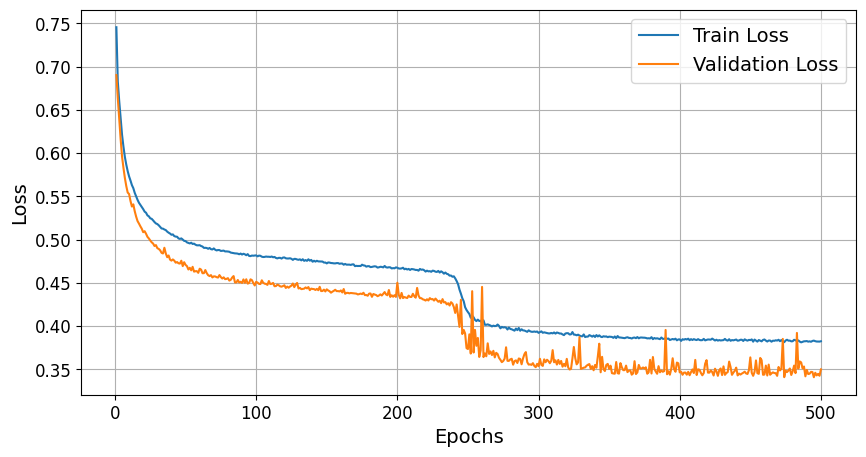

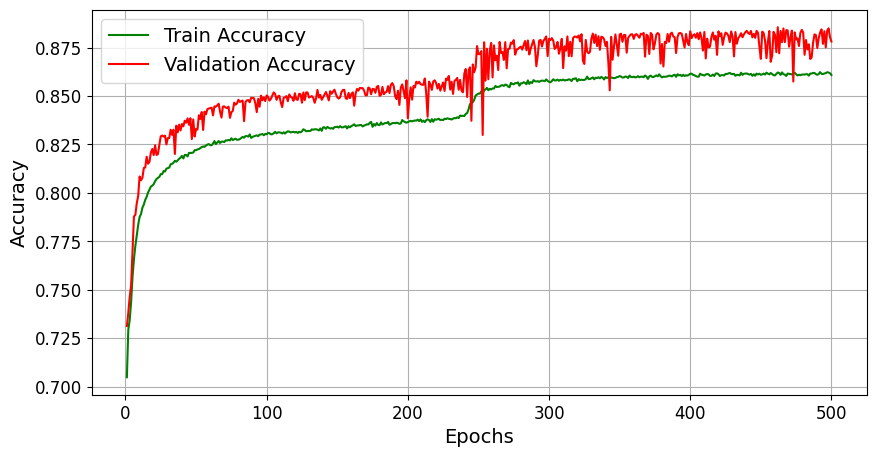

In [104]:
### PLOT TRAINING & VALIDATION LOSS ###
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
#plt.title("Training & Validation Loss")
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_val_loss.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, 'train_val_loss.pdf'), dpi=300, format ='pdf')
plt.show()

### PLOT TRAINING & VALIDATION ACCURACY ###
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy", color = 'green')
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy", color = 'red')
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
#plt.title("Training & Validation Accuracy")
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_val_accuracy.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, 'train_val_accuracy.pdf'), dpi=300, format ='pdf')
plt.show()

In [105]:
# Convert logits to predictions
X_train_normalized = X_train_normalized.permute(0, 2, 1)
X_val_normalized = X_val_normalized.permute(0, 2, 1)
X_test_normalized = X_test_normalized.permute(0, 2, 1)

y_val = y_val.view(-1, 1)
y_test = y_test.view(-1, 1)

y_pred_train = (torch.sigmoid(model(X_train_normalized)).detach().cpu().numpy() > 0.5).astype(int)
y_pred_val = (torch.sigmoid(model(X_val_normalized)).detach().cpu().numpy() > 0.5).astype(int)
y_pred_test = (torch.sigmoid(model(X_test_normalized)).detach().cpu().numpy() > 0.5).astype(int)

# Print classification reports
print("Training Set:")
report_train = classification_report(y_train, y_pred_train)
print(report_train)

print("Validation Set:")
report_val = classification_report(y_val, y_pred_val)
print(report_val)

print("Test Set:")
report_test = classification_report(y_test, y_pred_test)
print(report_test)

Training Set:
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91    161327
         1.0       0.81      0.81      0.81     72684

    accuracy                           0.88    234011
   macro avg       0.86      0.86      0.86    234011
weighted avg       0.88      0.88      0.88    234011

Validation Set:


ValueError: Found input variables with inconsistent numbers of samples: [97, 50145]

torch.Size([50146, 80, 1])
torch.Size([50146, 1])
tensor([[-3.5872],
        [-1.7865],
        [-0.3222],
        ...,
        [-2.2000],
        [-2.3412],
        [ 1.8309]])
tensor([[0.0269],
        [0.1435],
        [0.4201],
        ...,
        [0.0998],
        [0.0878],
        [0.8619]])
Accuracy: 0.8787


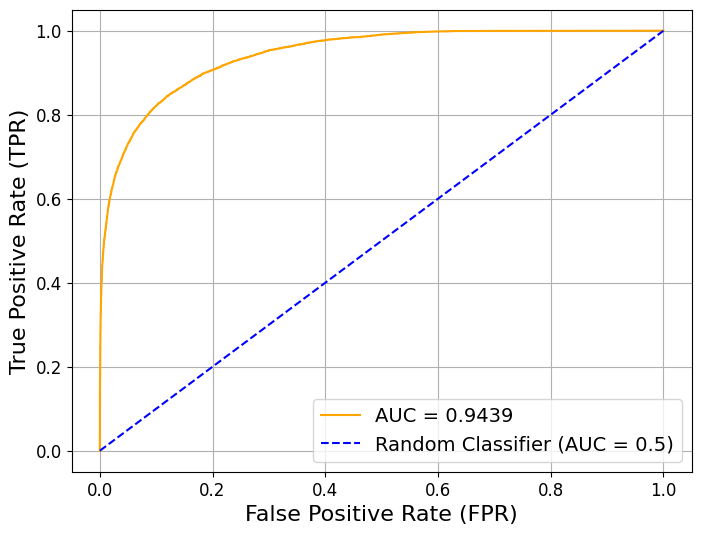

In [109]:
from sklearn.metrics import roc_auc_score, roc_curve

# set model to evaluation state
model.eval()

# Predict on the new dataset
with torch.no_grad():

    # Ensure the data is in float32 format
    X_test_norm = X_test_normalized.to(torch.float32)
    y_test = y_test.to(torch.float32)

    # Reshape y_val to (batch_size, 1)
    y_test = y_test.view(-1, 1)

    # Permute the validation data to [batch_size, 1, 60] (1 channel, 60 timepoints)
    X_test_norm = X_test_norm.permute(0, 1, 2)
    #X_test_norm = X_test_norm.permute(0, 2, 1) 

    print(X_test.shape)  # Should match the expected input shape of the model
    print(y_test.shape)

    y_pred_test = model(X_test_norm)
    print(y_pred_test)
    probabilities = torch.sigmoid(y_pred_test)
    print(probabilities)
    auc_score = roc_auc_score(y_test, y_pred_test)

    y_pred_test_labels = (probabilities > 0.5).int()

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_test_labels)

print(f'Accuracy: {accuracy:.4f}')


# Compute ROC Curve (FPR, TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label="Random Classifier (AUC = 0.5)")
# plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)", fontsize = 16)
plt.ylabel("True Positive Rate (TPR)", fontsize = 16)
plt.savefig(os.path.join(OUTPUT_PATH, 'roc_curve_RAW_CNN.png'), dpi=300)
plt.legend(fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()


In [110]:
print(classification_report(y_test, y_pred_test_labels, target_names=['Excitatory', 'Inhibitory']))

              precision    recall  f1-score   support

  Excitatory       0.91      0.91      0.91     34571
  Inhibitory       0.81      0.80      0.80     15575

    accuracy                           0.88     50146
   macro avg       0.86      0.86      0.86     50146
weighted avg       0.88      0.88      0.88     50146



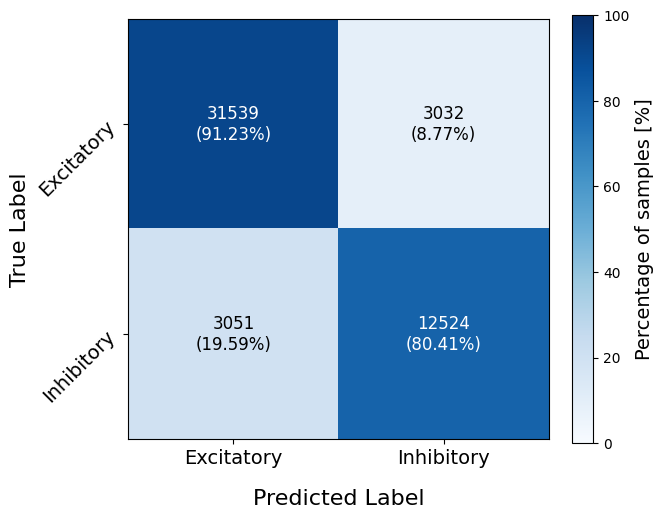

In [111]:
# Calculate confusion matrix
cm = confusion_matrix(y_test.numpy(), y_pred_test_labels.squeeze())

# Normalize to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm_percentage, interpolation='nearest', cmap='Blues', norm = norm)  # Use the Blues colormap

# Add a color bar
cbar = plt.colorbar(im, ax=ax, fraction = 0.046)
cbar.set_ticks([0, 20, 40, 60, 80, 100])  # Ensure it runs from 0 to 100
cbar.set_label("Percentage of samples [%]", fontsize=14)

# Set axis labels and titles
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(['Excitatory', 'Inhibitory'], fontsize = 14)
ax.set_yticklabels(['Excitatory', 'Inhibitory'], fontsize = 14, rotation=45)
plt.xlabel('Predicted Label', fontsize = 16, labelpad = 15)
plt.ylabel('True Label', fontsize = 16)
#plt.title('Confusion Matrix')

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Annotate the confusion matrix with numbers and percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        raw_count = cm[i, j]
        percent = cm_percentage[i, j]
        text = f"{raw_count}\n({percent:.2f}%)"
        
        # Get the RGBA color from the colormap
        rgba = im.cmap(norm(percent))  # Ensure it returns an RGBA tuple
        
        if isinstance(rgba, tuple) and len(rgba) == 4:
            r, g, b, _ = rgba  # Extract RGB values
        else:
            print(f"Unexpected colormap output at ({i},{j}):", rgba)
            continue  # Skip this iteration if color extraction fails
        
        # Calculate brightness (luminance)
        brightness = 0.299 * r + 0.587 * g + 0.114 * b  # Perceived brightness
        
        # Choose text color based on brightness
        font_color = "black" if brightness > 0.5 else "white"
        
        # Place the text with the determined font color
        ax.text(j, i, text, ha='center', va='center', color=font_color, fontsize=12)

plt.savefig(os.path.join(OUTPUT_PATH, 'confusion_matrix_RAW_CNN.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, 'confusion_matrix_RAW_CNN.pdf'), dpi=300, format='pdf')
plt.show()


torch.Size([50146, 1, 80])
X_test shape before squeeze: (50146, 1, 80)
34590
31539


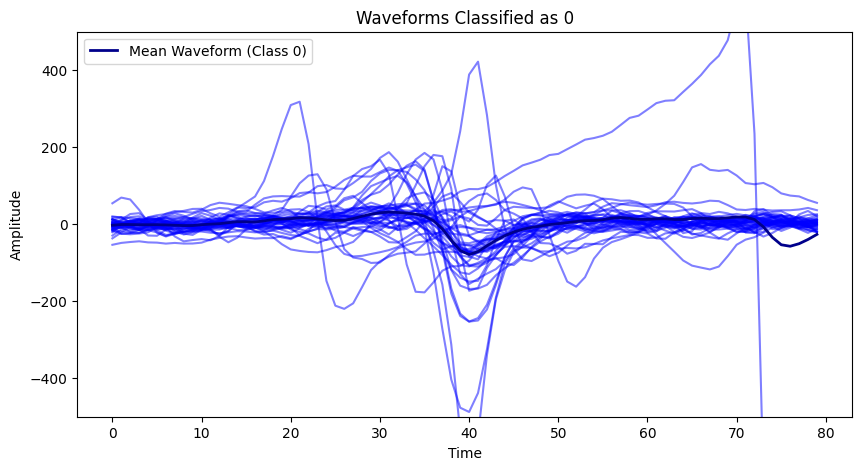

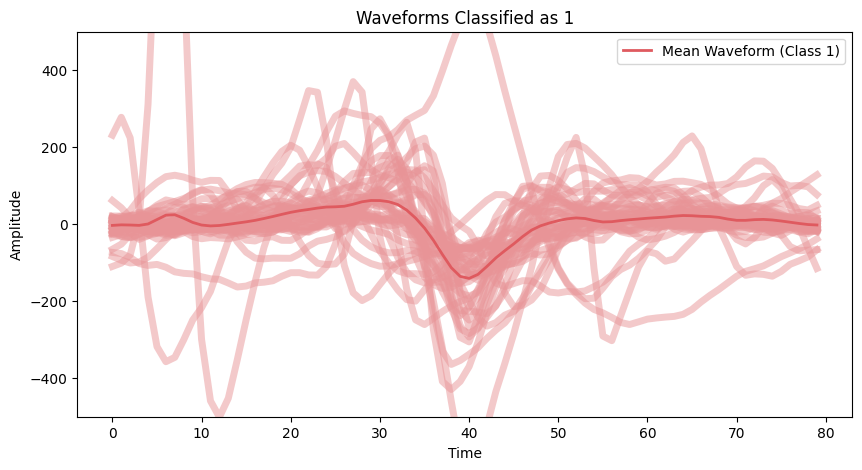

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import torch

path = os.path.join(OUTPUT_PATH, 'waveforms_classifications.pkl')

#X_test = X_test.permute(0, 2, 1)
print(X_test.shape)  # Should match the expected input shape of the mode

# Convert tensors to numpy arrays if needed
X_test_np = X_test.numpy() if isinstance(X_test, torch.Tensor) else X_test
y_pred_np = y_pred_test_labels.numpy() if isinstance(y_pred_test_labels, torch.Tensor) else y_pred_test_labels
y_test_np = y_test.numpy() if isinstance(y_test, torch.Tensor) else y_test

# Ensure the data is in the correct shape: (num_samples, num_timesteps)
if X_test_np.ndim == 3:  # Shape (2696, 1, 60)
    print("X_test shape before squeeze:", X_test_np.shape)
    X_test_np = X_test_np.squeeze(1)  # Remove the channel dimension -> (2696, 60)

# Ensure y_pred_np is a 1D array
y_pred_np = y_pred_np.flatten()
y_test_np = y_test_np.flatten()

# Filter waveforms based on predicted labels
waveforms_0 = X_test_np[y_pred_np == 0]  # Select waveforms where prediction is 0
waveforms_1 = X_test_np[y_pred_np == 1]  # Select waveforms where prediction is 1
print(len(waveforms_0))

# Get and save correctly classified waveforms
correct_waveforms_0 = X_test_np[(y_pred_np == 0) & (y_test_np == 0)]
correct_waveforms_1 = X_test_np[(y_pred_np == 1) & (y_test_np == 1)]
print(len(correct_waveforms_0))

# Get and save incorrectly classified waveforms
FN_waveforms = X_test_np[(y_pred_np == 0) & (y_test_np == 1)]
FP_waveforms = X_test_np[(y_pred_np == 1) & (y_test_np == 0)]

ground_truth_0 = X_test_np[y_test_np == 0]
ground_truth_1 = X_test_np[y_test_np == 1]

with open(path, 'wb') as f:
    pickle.dump({'classified_waveforms_0': waveforms_0, 'classified_waveforms_1': waveforms_1, 'correct_waveforms_0': correct_waveforms_0, 
                'correct_wavefoms_1': correct_waveforms_1, 'incorrect_waveforms_0': FN_waveforms, 'incorrect_waveforms_1': FP_waveforms,
                'ground_truth_0': ground_truth_0, 'ground_truth_1': ground_truth_1}, f)

# Slice only the first 10 waveforms per class
waveforms_0 = waveforms_0[10:50] if waveforms_0.shape[0] >= 10 else waveforms_0
waveforms_1 = waveforms_1[10:50] if waveforms_1.shape[0] >= 10 else waveforms_1

# Calculate average waveforms if there are samples in the class
mean_waveform_0 = waveforms_0.mean(axis=0) if waveforms_0.size > 0 else None
mean_waveform_1 = waveforms_1.mean(axis=0) if waveforms_1.size > 0 else None

# Plot first 10 waveforms and the mean waveform for class 0
if waveforms_0.size > 0:
    plt.figure(figsize=(10, 5))
    for waveform in waveforms_0:
        plt.plot(waveform, alpha=0.5, color="blue")  # Lighter blue for individual waveforms
    plt.plot(mean_waveform_0, color="darkblue", linewidth=2, label="Mean Waveform (Class 0)")  # Darker blue for mean
    #plt.ylim(-5, 5)  # Set y-axis range from -5 to 5
    plt.title("Waveforms Classified as 0")
    plt.ylim(-500,500)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()
else:
    print("⚠️ No waveforms classified as 0!")

# Plot first 10 waveforms and the mean waveform for class 1
if waveforms_1.size > 0:
    plt.figure(figsize=(10, 5))
    for waveform in waveforms_1:
        plt.plot(waveform, alpha=0.5, color="#e89497", linewidth = 5 )  # Lighter red for individual waveforms
    plt.plot(mean_waveform_1, color="#df5a5f", linewidth=2, label="Mean Waveform (Class 1)")  # Darker red for mean
    #plt.ylim(-5, 5)  # Set y-axis range from -5 to 5
    plt.title("Waveforms Classified as 1")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.ylim(-500,500)
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_PATH, 'waveforms_classified_as_1.png'), dpi=300)
    plt.savefig(os.path.join(OUTPUT_PATH, 'waveforms_classified_as_1.pdf'), dpi=300, format='pdf')
    plt.show()
else:
    print("⚠️ No waveforms classified as 1!")


## Test on DIV 49

In [113]:
df = df_original[df_original['cell_type'] != 'CoCulture']
df.dropna(inplace = True)
print(df['div'].unique())
DIVs = [49]

#take only chips '2034', '2074', '1908', '1821' and use isin method
df = df[df['chip_id'].isin([int(Chip_ID_ngn2[0]), int(Chip_ID_ngn2[1]), int(Chip_ID_gaba[0]), int(Chip_ID_gaba[1])])]
df['Type'] = df['cell_type'].apply(lambda x: 0 if x == 'NGN2' else 1)
df = df[(df['div'].astype(int).isin(DIVs))]

#make column Type that is 0 if cell_type == NGN2 and 1 if cell_type == GABA

df.reset_index(drop=True, inplace=True)
df

/tmp/ipykernel_26131/2187506140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


[140  35  23  28  56  49  12  19  16   8  27  22  21 101  17  89  63  42
  26 166 126   7  24  30  45  14  10]


,unit_id,waveform,chip_id,div,cell_type,area,Type
0,0,"[-16.08439, -14.625165, -12.946374, -3.0264323...",1765,49,NGN2,4,0
1,0,"[25.240623, 14.846899, 4.363906, 7.0472946, 13...",1765,49,NGN2,4,0
2,0,"[6.4896746, -7.037619, -11.3064995, -11.9008, ...",1765,49,NGN2,4,0
3,0,"[-26.645018, -9.466382, 3.4248295, 2.4369879, ...",1765,49,NGN2,4,0
4,0,"[10.309793, 1.0915186, -0.304098, 3.4063218, -...",1765,49,NGN2,4,0
...,...,...,...,...,...,...,...
225110,17,"[-9.927858, -4.2673097, 5.615817, 7.6223, 3.05...",1765,49,NGN2,0,0
225111,17,"[-7.4469857, -8.997736, -4.0191526, 1.5268439,...",1765,49,NGN2,0,0
225112,17,"[2.4528856, 10.774572, 14.214794, -0.30737236,...",1765,49,NGN2,0,0
225113,17,"[-7.6772575, -4.650227, -6.8456044, -2.7389572...",1765,49,NGN2,0,0


In [114]:
best_waveform_array = np.array(df['waveform'].tolist())
print(best_waveform_array.shape)
reshaped_data = best_waveform_array[..., np.newaxis]
print(reshaped_data.shape)

(225115, 80)
(225115, 80, 1)


In [115]:



df_eval_div49 = df[['waveform']].copy()

best_waveform_array_eval_div49 = np.array(df_eval_div49['waveform'].tolist())
print(best_waveform_array_eval_div49.shape)
reshaped_data_eval_div49 = best_waveform_array_eval_div49[..., np.newaxis]
print(reshaped_data_eval_div49.shape)

X_eval_div49 = reshaped_data_eval_div49
y_eval_div49 = df['Type'].values.astype(int)

X_tensor_eval_div49 = torch.tensor(X_eval_div49, dtype=torch.float32)
y_tensor_eval_div49 = torch.tensor(y_eval_div49, dtype=torch.float32)

#X_eval_normalized_div49 = (X_tensor_eval_div49 - X_min) / (X_max - X_min)
X_eval_normalized_div49 = (X_tensor_eval_div49 - mean) / std


# set model to evaluation state
model.eval()

# Predict on the new dataset
with torch.no_grad():

    # Reshape y_val to (batch_size, 1)
    y_tensor_eval_div49 = y_tensor_eval_div49.view(-1, 1)

    # Permute the validation data to [batch_size, 1, 60] (1 channel, 60 timepoints)
    X_tensor_eval_div49 = X_eval_normalized_div49.permute(0, 2, 1)

    print(X_tensor_eval_div49.shape)  # Should match the expected input shape of the model
    print(y_tensor_eval_div49.shape)

    y_pred_eval_div49 = model(X_tensor_eval_div49)
    print(y_pred_eval_div49)
    probabilities_div49 = torch.sigmoid(y_pred_eval_div49)
    print(probabilities_div49)
    y_pred_eval_labels_div49 = (probabilities_div49 > 0.5).int()
    print(y_pred_eval_labels_div49)

# Evaluate performance
accuracy_div49 = accuracy_score(y_tensor_eval_div49, y_pred_eval_labels_div49)
print(f"Accuracy on new dataset: {accuracy_div49:.4f}")
print("Classification Report:")
print(classification_report(
    y_tensor_eval_div49, 
    y_pred_eval_labels_div49, 
    target_names=['Excitatory', 'Inhibitory']
))

(225115, 80)
(225115, 80, 1)
torch.Size([225115, 1, 80])
torch.Size([225115, 1])
tensor([[ 0.6603],
        [ 1.1344],
        [-0.1388],
        ...,
        [-1.3546],
        [-1.1227],
        [-0.4165]])
tensor([[0.6593],
        [0.7567],
        [0.4653],
        ...,
        [0.2051],
        [0.2455],
        [0.3974]])
tensor([[1],
        [1],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int32)
Accuracy on new dataset: 0.5574
Classification Report:
              precision    recall  f1-score   support

  Excitatory       0.98      0.55      0.70    216122
  Inhibitory       0.07      0.75      0.12      8993

    accuracy                           0.56    225115
   macro avg       0.52      0.65      0.41    225115
weighted avg       0.95      0.56      0.68    225115



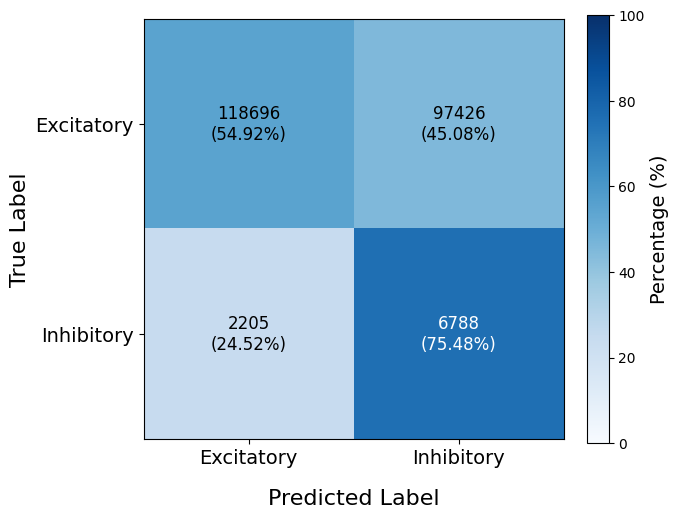

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_eval_div49, y_pred_eval_labels_div49.squeeze())

# Normalize to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm_percentage, interpolation='nearest', cmap='Blues', norm = norm)  # Use the Blues colormap

# Add a color bar
cbar = plt.colorbar(im, ax=ax, fraction = 0.046)
cbar.set_ticks([0, 20, 40, 60, 80, 100])  # Ensure it runs from 0 to 100
cbar.set_label("Percentage (%)", fontsize=14)

# Set axis labels and titles
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(['Excitatory', 'Inhibitory'], fontsize = 14)
ax.set_yticklabels(['Excitatory', 'Inhibitory'], fontsize = 14)
plt.xlabel('Predicted Label', fontsize = 16, labelpad = 15)
plt.ylabel('True Label', fontsize = 16)
#plt.title('Confusion Matrix')

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Annotate the confusion matrix with numbers and percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        raw_count = cm[i, j]
        percent = cm_percentage[i, j]
        text = f"{raw_count}\n({percent:.2f}%)"
        
        # Get the RGBA color from the colormap
        rgba = im.cmap(norm(percent))  # Ensure it returns an RGBA tuple
        
        if isinstance(rgba, tuple) and len(rgba) == 4:
            r, g, b, _ = rgba  # Extract RGB values
        else:
            print(f"Unexpected colormap output at ({i},{j}):", rgba)
            continue  # Skip this iteration if color extraction fails
        
        # Calculate brightness (luminance)
        brightness = 0.299 * r + 0.587 * g + 0.114 * b  # Perceived brightness
        
        # Choose text color based on brightness
        font_color = "black" if brightness > 0.5 else "white"
        
        # Place the text with the determined font color
        ax.text(j, i, text, ha='center', va='center', color=font_color, fontsize=12)
plt.savefig(os.path.join(OUTPUT_PATH, 'confusion_matrix_eval_div49.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, 'confusion_matrix_eval_div49.pdf'), dpi=300, format='pdf')
plt.show()


In [123]:
df = df_original[df_original['cell_type'] != 'CoCulture']
df.dropna(inplace = True)
print(df['div'].unique())
DIVs = [28]

#take only chips '2034', '2074', '1908', '1821' and use isin method
df = df[df['chip_id'].isin([int(Chip_ID_ngn2[2])])]
df['Type'] = df['cell_type'].apply(lambda x: 0 if x == 'NGN2' else 1)
df = df[(df['div'].astype(int).isin(DIVs))]

#make column Type that is 0 if cell_type == NGN2 and 1 if cell_type == GABA

df.reset_index(drop=True, inplace=True)
df


[140  35  23  28  56  49  12  19  16   8  27  22  21 101  17  89  63  42
  26 166 126   7  24  30  45  14  10]


/tmp/ipykernel_26131/1576676186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


,unit_id,waveform,chip_id,div,cell_type,area,Type
0,0,"[66.997375, 60.503063, 53.423443, 57.375874, 5...",1821,28,NGN2,1,0
1,0,"[73.11099, 90.97704, 89.05578, 70.78488, 85.63...",1821,28,NGN2,1,0
2,0,"[74.50533, 80.53107, 81.42038, 82.8803, 87.919...",1821,28,NGN2,1,0
3,0,"[58.0803, 71.71565, 72.90417, 70.23048, 77.460...",1821,28,NGN2,1,0
4,0,"[83.008255, 64.84628, 71.230316, 81.06619, 80....",1821,28,NGN2,1,0
...,...,...,...,...,...,...,...
93252,106,"[-52.73243, -45.634796, -26.526926, -13.59329,...",1821,28,NGN2,5,0
93253,106,"[-23.159893, -14.273773, -11.666779, -18.05266...",1821,28,NGN2,5,0
93254,106,"[-26.369362, -24.665697, -25.744818, -21.39202...",1821,28,NGN2,5,0
93255,106,"[-37.19794, -40.693645, -42.035107, -31.709667...",1821,28,NGN2,5,0


In [124]:
best_waveform_array = np.array(df['waveform'].tolist())
print(best_waveform_array.shape)
reshaped_data = best_waveform_array[..., np.newaxis]
print(reshaped_data.shape)

(93257, 80)
(93257, 80, 1)


In [125]:
X_eval = reshaped_data
y_eval = df['Type'].values

X_tensor_eval = torch.tensor(X_eval, dtype=torch.float32)
y_tensor_eval = torch.tensor(y_eval, dtype=torch.float32)

#X_eval_normalized = (X_tensor_eval - X_min) / (X_max - X_min)
X_eval_normalized = (X_tensor_eval - mean) / std



In [126]:
# set model to evaluation state
model.eval()

# Predict on the new dataset
with torch.no_grad():

    # Reshape y_val to (batch_size, 1)
    y_tensor_eval = y_tensor_eval.view(-1, 1)

    # Permute the validation data to [batch_size, 1, 60] (1 channel, 60 timepoints)
    X_tensor_eval = X_eval_normalized.permute(0, 2, 1)

    y_pred_eval = model(X_tensor_eval)
    print(y_pred_eval)
    probabilities = torch.sigmoid(y_pred_eval)
    print(probabilities)
    y_pred_eval_labels = (probabilities > 0.5).int()
    print(y_pred_eval_labels.shape)

# Evaluate performance
accuracy = accuracy_score(y_tensor_eval, y_pred_eval_labels)
print(f"Accuracy on new dataset: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(
    y_tensor_eval, 
    y_pred_eval_labels, 
    target_names=['Excitatory', 'Inhibitory']
))

tensor([[1.4419],
        [1.8457],
        [2.6972],
        ...,
        [3.3240],
        [3.5096],
        [3.1107]])
tensor([[0.8087],
        [0.8636],
        [0.9369],
        ...,
        [0.9652],
        [0.9710],
        [0.9573]])
torch.Size([93257, 1])
Accuracy on new dataset: 0.3116
Classification Report:
              precision    recall  f1-score   support

  Excitatory       1.00      0.31      0.48     93257
  Inhibitory       0.00      0.00      0.00         0

    accuracy                           0.31     93257
   macro avg       0.50      0.16      0.24     93257
weighted avg       1.00      0.31      0.48     93257



/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

/tmp/ipykernel_26131/4194313055.py:5: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100


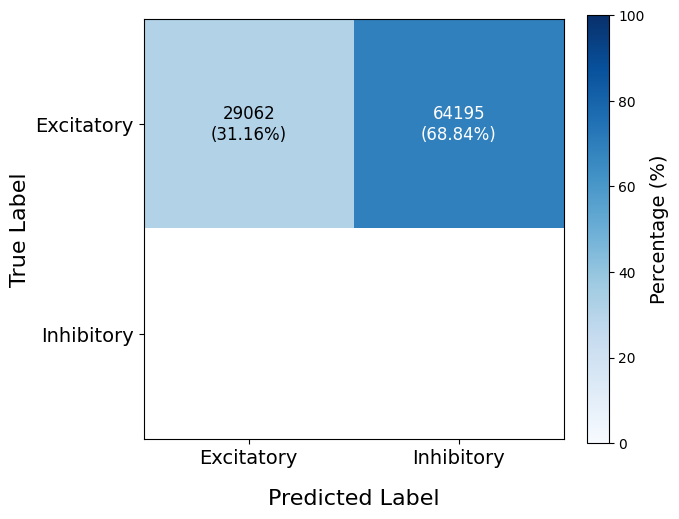

In [127]:
# Calculate confusion matrix
cm = confusion_matrix(y_eval, y_pred_eval_labels.squeeze())

# Normalize to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm_percentage, interpolation='nearest', cmap='Blues', norm = norm)  # Use the Blues colormap

# Add a color bar
cbar = plt.colorbar(im, ax=ax, fraction = 0.046)
cbar.set_ticks([0, 20, 40, 60, 80, 100])  # Ensure it runs from 0 to 100
cbar.set_label("Percentage (%)", fontsize=14)

# Set axis labels and titles
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(['Excitatory', 'Inhibitory'], fontsize = 14)
ax.set_yticklabels(['Excitatory', 'Inhibitory'], fontsize = 14)
plt.xlabel('Predicted Label', fontsize = 16, labelpad = 15)
plt.ylabel('True Label', fontsize = 16)
#plt.title('Confusion Matrix')

# Normalize the confusion matrix for text color mapping
norm = Normalize(vmin=0, vmax=100)  # Ensure min is 0

# Annotate the confusion matrix with numbers and percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        raw_count = cm[i, j]
        percent = cm_percentage[i, j]
        text = f"{raw_count}\n({percent:.2f}%)"
        
        # Get the RGBA color from the colormap
        rgba = im.cmap(norm(percent))  # Ensure it returns an RGBA tuple
        
        if isinstance(rgba, tuple) and len(rgba) == 4:
            r, g, b, _ = rgba  # Extract RGB values
        else:
            print(f"Unexpected colormap output at ({i},{j}):", rgba)
            continue  # Skip this iteration if color extraction fails
        
        # Calculate brightness (luminance)
        brightness = 0.299 * r + 0.587 * g + 0.114 * b  # Perceived brightness
        
        # Choose text color based on brightness
        font_color = "black" if brightness > 0.5 else "white"
        
        # Place the text with the determined font color
        ax.text(j, i, text, ha='center', va='center', color=font_color, fontsize=12)

plt.savefig(os.path.join(OUTPUT_PATH, 'confusion_matrix_eval_div28chip.png'), dpi=300)
plt.savefig(os.path.join(OUTPUT_PATH, 'confusion_matrix_eval_div28chipnew.pdf'), dpi=300, format='pdf')

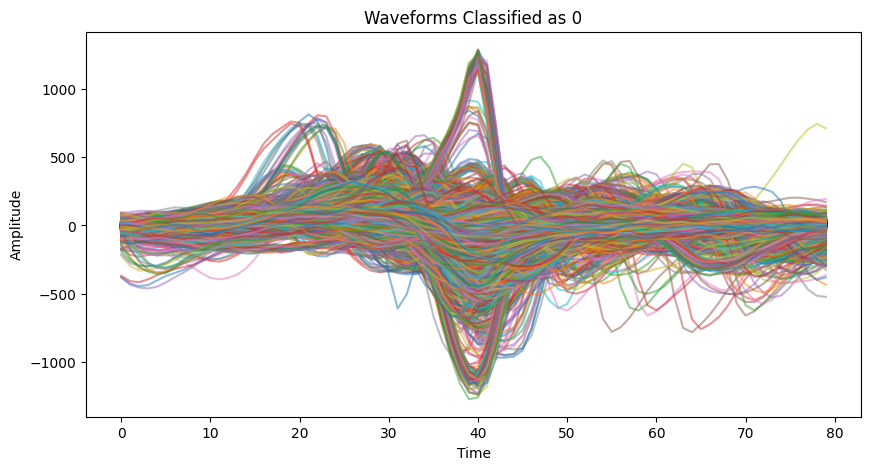

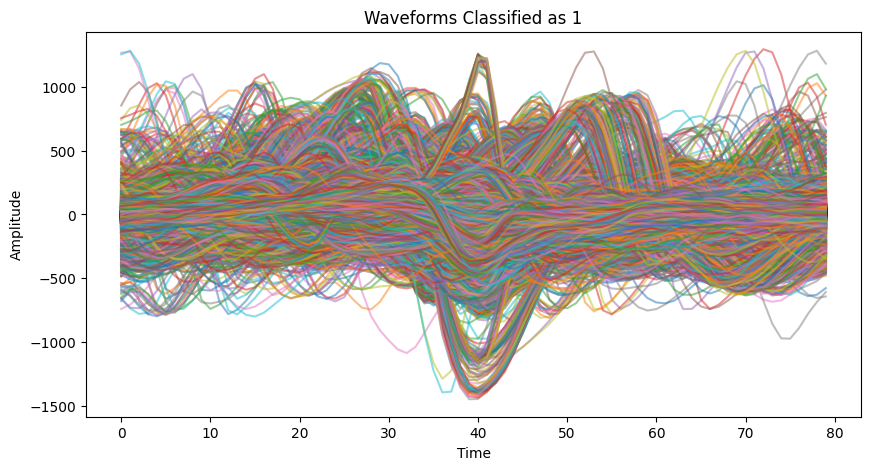

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# Convert tensors to numpy arrays if needed
X_eval_np = X_eval.numpy() if isinstance(X_eval, torch.Tensor) else X_eval
y_pred_np = y_pred_eval_labels.numpy() if isinstance(y_pred_eval_labels, torch.Tensor) else y_pred_eval_labels

# Ensure the data is in the correct shape: (num_samples, num_timesteps)
if X_eval_np.ndim == 3:  # If shape is (num_samples, num_timesteps, 1)
    X_eval_np = X_eval_np.squeeze(-1)  # Remove last dimension

# Ensure y_pred_np is 1D (should be shape (num_samples,))
y_pred_np = y_pred_np.flatten()

# Filter waveforms based on predicted labels
waveforms_0 = X_eval_np[y_pred_np == 0]  # Select waveforms where prediction is 0
waveforms_1 = X_eval_np[y_pred_np == 1]  # Select waveforms where prediction is 1

# Plot waveforms classified as 0
plt.figure(figsize=(10, 5))
for waveform in waveforms_0:
    plt.plot(waveform, alpha=0.5)  # Add transparency for better visibility
#plt.plot(np.mean(waveforms_0, axis=0), alpha=0.5)
plt.title("Waveforms Classified as 0")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Plot waveforms classified as 1
plt.figure(figsize=(10, 5))
for waveform in waveforms_1:
    plt.plot(waveform, alpha=0.5)
plt.title("Waveforms Classified as 1")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()
